# Graph worlds

This environment demonstrates agents that can navigate a graph and find an object. Object is only visible when agent is at the same location as the object.

In [1]:
import jax.numpy as jnp
from jax import random as jr
import networkx as nx

from pymdp.envs import GraphEnv
from pymdp.envs.graph_worlds import generate_connected_clusters
from pymdp.agent import Agent
from pymdp.envs.rollout import rollout

import matplotlib.pyplot as plt

key = jr.PRNGKey(0)

Start by generating a graph of locations

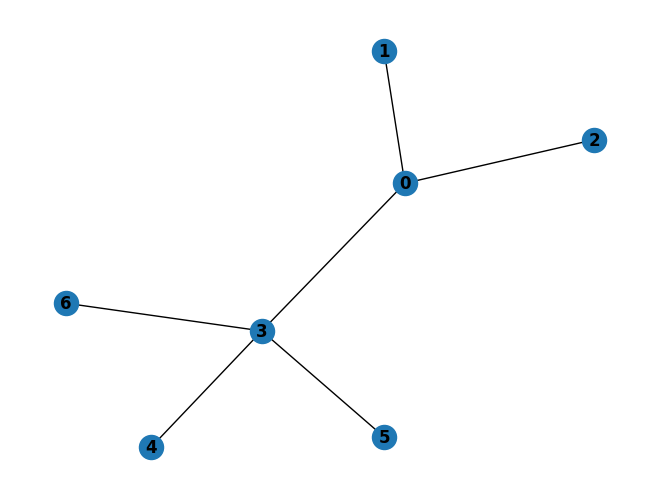

In [2]:
graph, _ = generate_connected_clusters(cluster_size=3, connections=2)
nx.draw(graph, with_labels=True, font_weight="bold")

Now we can create a GraphEnv given this graph. We specify two object locations and two agent locations. This will effectively create the environment with a batch size of 2.

In [3]:
env = GraphEnv(graph, object_locations=[3, 5], agent_locations=[0, 1])

To create an Agent, we reuse the environment's A and B tensors, but give the agent a uniform initial belief about the object location, and a preference to find (see) the object.

In [4]:
A = [a.copy() for a in env.params["A"]]
B = [b.copy() for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[:, 1].set(1.0)

D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]

agent = Agent(A, B, C, D, A_dependencies=A_dependencies, B_dependencies=B_dependencies, policy_len=2, batch_size=2)

Using the `rollout` function, we can easily simulate two agents in parallel for 10 timesteps...

In [5]:
last, result, env = rollout(agent, env, 10, key)

if you want to continue, call `rollout` again but with `initial_carry=last`

In [6]:
last, result2, env = rollout(agent, env, 10, key, initial_carry=last)

The result dict contains the executed actions, observations, environment state and beliefs over states and policies.

In [7]:
result.keys()

dict_keys(['G', 'action', 'empirical_prior', 'env', 'observation', 'qpi', 'qs'])

The beliefs result is an array for each state factor, and the shape is [batch_size x time x factor_size]

In [8]:
print(len(result["qs"]))
print(result["qs"][0].shape)

2
(2, 11, 7)


We can plot the agent's beliefs over time.

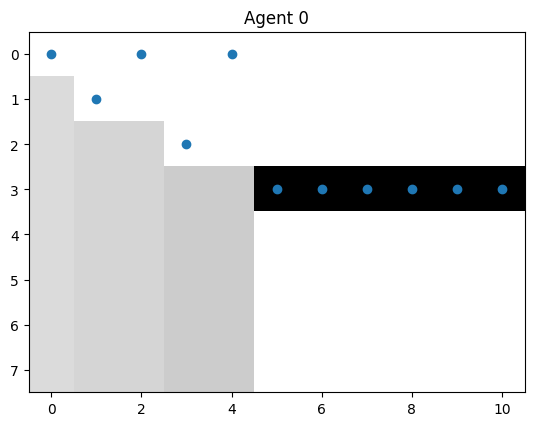

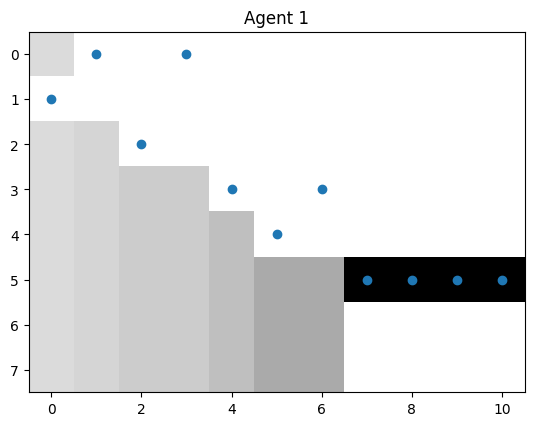

In [9]:
def plot_results(result, agent_idx=0):
    """Plot the results of the agent's beliefs and actions."""
    fig, ax = plt.subplots()
    ax.title.set_text(f"Agent {agent_idx}")

    # Plot the agent location belief as blue dots
    T = result["qs"][0].shape[1]
    locations = [jnp.argmax(result["qs"][0][agent_idx, t, :]) for t in range(T)]
    ax.scatter(jnp.arange(T), locations, c="tab:blue")

    # Plot object location beliefs as greyscale intensity
    ax.imshow(result["qs"][1][agent_idx, :, :].T, cmap="gray_r", vmin=0.0, vmax=1.0)

plot_results(result, agent_idx=0)
plot_results(result, agent_idx=1)

If you cannot use the `rollout` method, i.e. when you are using a 3rd party environment that is not jax jit compatible, you can construct your own loop using the `infer_and_plan` function.

In [11]:
import jax.tree_util as jtu
from pymdp.envs.rollout import infer_and_plan

rng_key = jr.PRNGKey(0)

# start with None action, and expand agent.D to add time dimension
action = -jnp.ones((agent.batch_size, len(agent.num_controls)), dtype=jnp.int32)
qs = jtu.tree_map(lambda x: jnp.expand_dims(x, -2), agent.D)

# reset environment and get initial observation
keys = jr.split(rng_key, agent.batch_size + 1)
rng_key = keys[0]
observation, env = env.reset(keys[1:])

for i in range(10):
    # random keys
    keys = jr.split(rng_key, agent.batch_size + 2)
    rng_key = keys[0]

    # infer and plan
    _, action, qs, _ = infer_and_plan(agent, qs, observation, action, keys[1])

    # step the environment
    observation, env = env.step(keys[2:], action)

    print(f"Step {i+1}: Action taken: {action}, Observation: {observation}")

Step 1: Action taken: [[1 0]
 [0 0]], Observation: [Array([[1.],
       [0.]], dtype=float32), Array([[0.],
       [0.]], dtype=float32)]
Step 2: Action taken: [[0 0]
 [2 0]], Observation: [Array([[0.],
       [2.]], dtype=float32), Array([[0.],
       [0.]], dtype=float32)]
Step 3: Action taken: [[2 0]
 [0 0]], Observation: [Array([[2.],
       [0.]], dtype=float32), Array([[0.],
       [0.]], dtype=float32)]
Step 4: Action taken: [[0 0]
 [3 0]], Observation: [Array([[0.],
       [3.]], dtype=float32), Array([[0.],
       [0.]], dtype=float32)]
Step 5: Action taken: [[3 0]
 [4 0]], Observation: [Array([[3.],
       [4.]], dtype=float32), Array([[1.],
       [0.]], dtype=float32)]
Step 6: Action taken: [[1 0]
 [3 0]], Observation: [Array([[3.],
       [3.]], dtype=float32), Array([[1.],
       [0.]], dtype=float32)]
Step 7: Action taken: [[1 0]
 [5 0]], Observation: [Array([[3.],
       [5.]], dtype=float32), Array([[1.],
       [1.]], dtype=float32)]
Step 8: Action taken: [[1 0]
 [0 0